In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
#import umap
import numpy as np
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('pre-processed-articles.csv')

In [3]:
df = df.dropna(subset=['text', 'stance'])
df['text'] = df['text'].fillna('')
df['stance'] = df['stance'].str.lower()

# ✨ combine title + text
df['full_text'] = df['title'].fillna('') + ' ' + df['text']

# encode stance
le = LabelEncoder()
df['stance_encoded'] = le.fit_transform(df['stance'])
print(le.classes_)

['anti' 'pro']


In [4]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('using device:', device)

using device: mps


In [5]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert = AutoModel.from_pretrained('distilbert-base-uncased').to(device)
bert.eval()

RuntimeError: Failed to import transformers.models.distilbert.modeling_distilbert because of the following error (look up to see its traceback):
module 'ml_dtypes' has no attribute 'float4_e2m1fn'

In [ ]:
class HardTripletTextDataset(Dataset):
    def __init__(self, df, tokenizer, model, device):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.labels = df['stance_encoded'].values
        
        # precompute embeddings for mining
        self.embeddings = self.compute_all_embeddings()

        # build nearest neighbors
        self.nn = NearestNeighbors(n_neighbors=10, metric='cosine')
        self.nn.fit(self.embeddings)

    def compute_all_embeddings(self):
        all_text = self.df['full_text'].tolist()
        input_ids, attention_mask = encode_text(all_text, self.tokenizer, self.device)
        with torch.no_grad():
            emb = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return emb.cpu().numpy()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_text = self.df.loc[idx, 'full_text']
        anchor_label = self.labels[idx]

        distances, indices = self.nn.kneighbors([self.embeddings[idx]])
        indices = indices.flatten()

        # select hard positive
        pos_idx = None
        for i in indices[::-1]:  # farthest neighbor first
            if i != idx and self.labels[i] == anchor_label:
                pos_idx = i
                break
        if pos_idx is None:
            pos_idx = idx  # fallback: use anchor as positive (no harm for triplet loss)

        # select hard negative
        neg_idx = None
        for i in indices:  # closest neighbor first
            if self.labels[i] != anchor_label:
                neg_idx = i
                break
        if neg_idx is None:
            neg_idx = idx  # fallback: use anchor as negative (loss will be near 0)

        positive_text = self.df.loc[pos_idx, 'full_text']
        negative_text = self.df.loc[neg_idx, 'full_text']

        return anchor_text, positive_text, negative_text, anchor_label

def encode_text(text_list, tokenizer, device):
    encodings = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    return input_ids, attention_mask

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.embedding_dim = 768
        self.fc = nn.Linear(self.embedding_dim, 128)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        return self.fc(pooled_output)

In [ ]:
def train_triplet(model, dataset, epochs=10, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.TripletMarginLoss(margin=0.8)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for anchor, positive, negative, _ in pbar:
            anchor_ids, anchor_mask = encode_text(anchor, tokenizer, device)
            positive_ids, positive_mask = encode_text(positive, tokenizer, device)
            negative_ids, negative_mask = encode_text(negative, tokenizer, device)

            anchor_emb = model(anchor_ids, anchor_mask)
            positive_emb = model(positive_ids, positive_mask)
            negative_emb = model(negative_ids, negative_mask)

            loss = criterion(anchor_emb, positive_emb, negative_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
    
    return losses

In [ ]:
def plot_loss(losses):
    plt.plot(losses, marker='o')
    plt.title("Triplet Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [ ]:
def visualize_embeddings(model, df, n_samples=200):
    model.eval()
    
    texts = df.sample(n=n_samples, random_state=42)['full_text'].tolist()
    labels = df.sample(n=n_samples, random_state=42)['stance_encoded'].tolist()
    
    input_ids, attention_mask = encode_text(texts, tokenizer, device)
    embeddings = model(input_ids, attention_mask).detach().cpu().numpy()
    
    reducer = umap.UMAP()
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title('UMAP projection of Embeddings')
    plt.colorbar(scatter, label='Stance')
    plt.show()
    
    return emb_2d, labels

In [ ]:
# build dataset with hard mining
dataset = HardTripletTextDataset(df, tokenizer, bert, device)


In [ ]:
dataset.df

,id,stance,title,title_tokens,source,author,url,date,text,tokens,embedding,full_text,stance_encoded
0,eda814f0-b7b2-43e3-8be9-6a7c170f19b4,pro,mapping attacks on lgbtq rights in u.s. state ...,"['mapping', 'attack', 'lgbtq', 'right', 'state...",aclu,none listed,https://www.aclu.org/legislative-attacks-on-lg...,4/11/2025,no text content,"['text', 'content']",NaN,mapping attacks on lgbtq rights in u.s. state ...,1
1,e8ab96b3-eb08-41db-95ac-a9e098ec484e,pro,the human toll of trump's anti-trans crusade,"['human', 'toll', 'trump', 'anti', 'trans', 'c...",aclu,lisa francois,https://www.aclu.org/news/lgbtq-rights/the-hum...,4/3/25,president donald trump’s assault on transgende...,"['president', 'donald', 'trump', 'assault', 't...",NaN,the human toll of trump's anti-trans crusade p...,1
2,5ee886ac-3f21-42b5-b842-aeb2916552d6,pro,perkins et al. v. state (hb 121),"['perkin', 'et', 'al', 'state', 'hb']",aclu,none listed,https://www.aclu.org/cases/perkins-et-al-v-state,4/3/25,"hb 121, which took effect on march 27, 2025, i...","['hb', 'take', 'effect', 'march', 'draconian',...",NaN,"perkins et al. v. state (hb 121) hb 121, which...",1
3,3fa9bb9d-ce25-4325-b91f-acd8d8ff192a,anti,montana senate endorses bill tying bathrooms t...,"['montana', 'senate', 'endorse', 'bill', 'tie'...",kpax (local news),jonathon ambarian,https://www.kpax.com/news/montana-senate-endor...,2/11/2025,a bill that would require transgender people i...,"['bill', 'require', 'transgend', 'people', 'mo...",NaN,montana senate endorses bill tying bathrooms t...,0
4,e53c9e0b-0b98-4098-b1a4-867f306bcda4,pro,library patrons sue greenville county over wid...,"['library', 'patron', 'sue', 'greenville', 'co...",aclu,none listed,https://www.aclu.org/press-releases/library-pa...,3/26/25,"greenville, s.c. – local library patrons, with...","['greenville', 'local', 'library', 'patron', '...",NaN,library patrons sue greenville county over wid...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,badce5c7-c381-4be9-bc42-14cd92b79076,anti,democrats’ civil war over transgenderism heats up,"['democrat', 'civil', 'war', 'transgenderism',...",the american spectator,ellie gardey holmes,https://spectator.org/democrats-civil-war-over...,3/17/2025,"one by one, democrats are deciding that the ji...","['democrats', 'decide', 'jig', 'time', 'join',...",NaN,democrats’ civil war over transgenderism heats...,0
240,deadd975-93f3-4c13-878f-06e5938d5493,anti,detrans awareness day comes with a warning,"['detrans', 'awareness', 'day', 'come', 'warni...",the american spectator,debra j. saunders,https://spectator.org/detrans-awareness-day-co...,3/12/2025,"washington — “i realized i am a guinea pig,” f...","['washington', 'realize', 'guinea', 'pig', 'fo...",NaN,detrans awareness day comes with a warning was...,0
241,96d8d466-b283-451c-bf64-4fa2c6d67677,anti,3 major new developments in trump’s battle aga...,"['major', 'new', 'development', 'trump', 'batt...",the american spectator,robert gagnon,https://spectator.org/3-new-dev-trump-battle-a...,2/4/2025,trump’s turnaround of u.s. policy on the scour...,"['trump', 'turnaround', 'policy', 'scourge', '...",NaN,3 major new developments in trump’s battle aga...,0
242,4c4640b2-ca6e-4201-a9a1-6b8ba30131df,anti,trump’s executive order ends ‘trans’ tyranny a...,"['trump', 'executive', 'order', 'end', 'trans'...",the american spectator,robert gagnon,https://spectator.org/trump-executive-order-en...,1/22/2025,"thanks to donald trump’s new executive order, ...","['thank', 'donald', 'trump', 'new', 'executive...",NaN,trump’s executive order ends ‘trans’ tyranny a...,0


In [ ]:

# build model
model = EmbeddingNet(bert).to(device)


In [ ]:

# train
losses = train_triplet(model, dataset, epochs=10, batch_size=16)


Epoch 10/10: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it, loss=0.901]


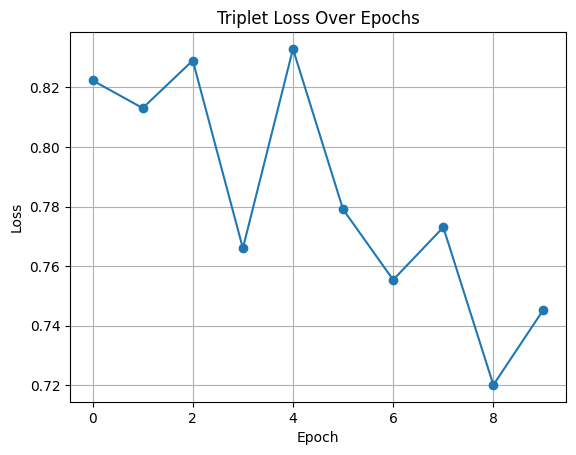

In [ ]:

# plot loss
plot_loss(losses)


/Users/georgiavonminden/virtual-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


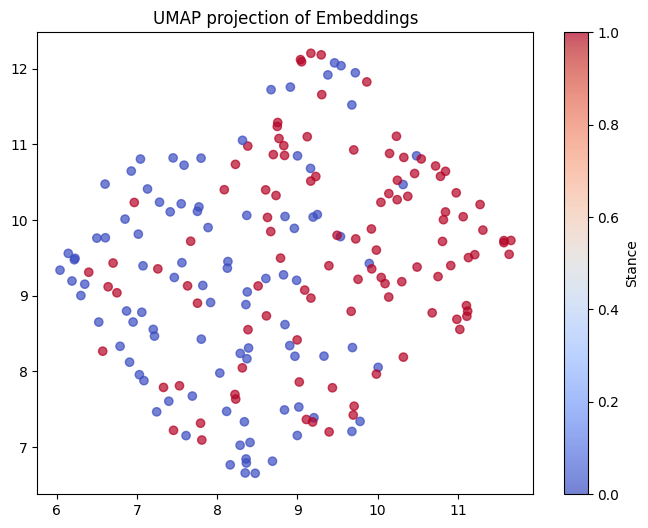

In [ ]:

# visualize
embeddings_2d, labels = visualize_embeddings(model, df)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
def plot_decision_boundary(embeddings_2d, labels):
    X = np.array(embeddings_2d)
    y = np.array(labels)

    # split into train/test for plotting (optional but nice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

    # train simple logistic regression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # plot the background
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)

    # plot the points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title("Decision Boundary on UMAP Embeddings")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.colorbar(scatter, label='Stance')
    plt.show()

    # report train/test accuracy
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

In [ ]:
embeddings_2d, labels = visualize_embeddings(model, df)

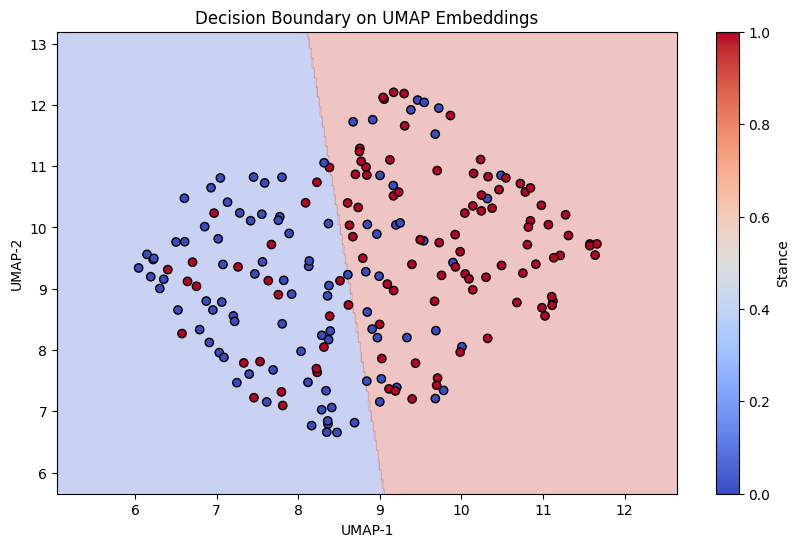

Train Accuracy: 0.706
Test Accuracy: 0.775


In [ ]:
plot_decision_boundary(embeddings_2d, labels)

In [ ]:
class BatchMiner:
    def __init__(self, embeddings, labels, n_neighbors=20):
        self.embeddings = embeddings
        self.labels = labels
        self.n_neighbors = n_neighbors

        self.nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
        self.nn.fit(embeddings)

    def get_hard_triplets(self):
        triplets = []
        for idx, emb in enumerate(self.embeddings):
            label = self.labels[idx]
            distances, indices = self.nn.kneighbors([emb])
            indices = indices.flatten()

            pos_idx = None
            neg_idx = None

            for i in indices[::-1]:  # farthest first for positive
                if i != idx and self.labels[i] == label:
                    pos_idx = i
                    break
            for i in indices:  # closest first for negative
                if self.labels[i] != label:
                    neg_idx = i
                    break

            if pos_idx is not None and neg_idx is not None:
                triplets.append((idx, pos_idx, neg_idx))
        
        return triplets

In [ ]:
class TripletDatasetFromIndices(Dataset):
    def __init__(self, df, triplets):
        self.df = df.reset_index(drop=True)
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]

        anchor_text = self.df.loc[anchor_idx, 'full_text']
        positive_text = self.df.loc[pos_idx, 'full_text']
        negative_text = self.df.loc[neg_idx, 'full_text']
        anchor_label = self.df.loc[anchor_idx, 'stance_encoded']

        return anchor_text, positive_text, negative_text, anchor_label

In [ ]:
# recompute all embeddings
all_texts = df['full_text'].tolist()
input_ids, attention_mask = encode_text(all_texts, tokenizer, device)

with torch.no_grad():
    full_embeddings = bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]

def encode_texts_batched(text_list, tokenizer, model, device, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Encoding Batches"):
        batch_texts = text_list[i:i+batch_size]
        input_ids, attention_mask = encode_text(batch_texts, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_emb = outputs.last_hidden_state[:, 0]
        embeddings.append(batch_emb.cpu())
    return torch.cat(embeddings, dim=0)
full_embeddings = encode_texts_batched(all_texts, tokenizer, bert, device)
# now mine hard triplets
miner = BatchMiner(full_embeddings.cpu().numpy(), df['stance_encoded'].values)
triplets = miner.get_hard_triplets()

# build dataset
dataset = TripletDatasetFromIndices(df, triplets)

RuntimeError: MPS backend out of memory (MPS allocated: 14.02 GB, other allocations: 2.87 GB, max allowed: 18.13 GB). Tried to allocate 2.86 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).